In [44]:
#load and vis a few seqmented images in the images_CNN folder
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import Image, ImageSequence
img_list = glob.glob('images_CNN/F?_im.TIF')+glob.glob('images_CNN/F??_im.TIF')
img_list = sorted(img_list)
mask_list = glob.glob('images_CNN/*mask.h5')
mask_list = sorted(mask_list)
fluo_gfp = glob.glob('images_CNN/*GFP_im.TIF')
fluo_gfp = sorted(fluo_gfp)
fluo_rfp = glob.glob('images_CNN/*RFP_im.TIF')
fluo_rfp = sorted(fluo_rfp)
print( len(img_list), len(mask_list) , len(fluo_gfp), len(fluo_rfp  )   )
dataset = {}
for i in range(len(img_list)):
    dataset[i] = { 'img': img_list[i], 'mask': mask_list[i], 'gfp': fluo_gfp[i], 'rfp': fluo_rfp[i]  }
print(dataset)



11 11 11 11
{0: {'img': 'images_CNN/F10_im.TIF', 'mask': 'images_CNN/F10_mask.h5', 'gfp': 'images_CNN/F10_GFP_im.TIF', 'rfp': 'images_CNN/F10_RFP_im.TIF'}, 1: {'img': 'images_CNN/F11_im.TIF', 'mask': 'images_CNN/F11_mask.h5', 'gfp': 'images_CNN/F11_GFP_im.TIF', 'rfp': 'images_CNN/F11_RFP_im.TIF'}, 2: {'img': 'images_CNN/F1_im.TIF', 'mask': 'images_CNN/F1_mask.h5', 'gfp': 'images_CNN/F1_GFP_im.TIF', 'rfp': 'images_CNN/F1_RFP_im.TIF'}, 3: {'img': 'images_CNN/F2_im.TIF', 'mask': 'images_CNN/F2_mask.h5', 'gfp': 'images_CNN/F2_GFP_im.TIF', 'rfp': 'images_CNN/F2_RFP_im.TIF'}, 4: {'img': 'images_CNN/F3_im.TIF', 'mask': 'images_CNN/F3_mask.h5', 'gfp': 'images_CNN/F3_GFP_im.TIF', 'rfp': 'images_CNN/F3_RFP_im.TIF'}, 5: {'img': 'images_CNN/F4_im.TIF', 'mask': 'images_CNN/F4_mask.h5', 'gfp': 'images_CNN/F4_GFP_im.TIF', 'rfp': 'images_CNN/F4_RFP_im.TIF'}, 6: {'img': 'images_CNN/F5_im.TIF', 'mask': 'images_CNN/F5_mask.h5', 'gfp': 'images_CNN/F5_GFP_im.TIF', 'rfp': 'images_CNN/F5_RFP_im.TIF'}, 7: {'i

In [45]:
from PIL import Image, ImageEnhance

def adjust_brightness_contrast(input_image_path, output_image_path, brightness=3, contrast=3):
    # Open the image
    image = Image.open(input_image_path)
    
    # Adjust brightness
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(brightness)
    
    # Adjust contrast
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(contrast)
    
    # Save the modified image
    image.save(output_image_path)

In [46]:

import skimage.measure as measure
import copy

def output_contours( m , cl , verbose = False):
    contours = measure.find_contours(m, .9)
    if verbose:
        plt.imshow(m)
        for n, contour in enumerate(contours):
            plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
        plt.show()

    #output contours of each mask to file
    #divide x and y coordinates by total image size
    #to get values between 0 and 1  
    #<class-index> <x1> <y1> <x2> <y2> ... <xn> <yn>
    lines = []
    for c in contours:
        coords = []
        for i in range(0,c.shape[0]):
            coords.append( (float(c[i][1]) / m.shape[0]) )
            coords.append( (float(c[i][0]) / m.shape[1]) )
        line = str(cl) + ' ' + ' '.join([str(c) for c in coords]) + '\n'
        lines.append(line)
    return lines

def split_mask(mask, crop = 1024):
    #custom encoding with 3 classes
    mask = mask[0:crop, 0:crop]
    mask1 = copy.deepcopy(mask)
    mask1[ (mask1 > 0) & (mask1 < 1000)] =  1
    mask1[mask1 > 1] = 0 

    mask2 = copy.deepcopy(mask)
    mask2[mask2 == 1] = 0
    mask2[ (mask2 > 1000) & (mask2 < 2000)] =  1
    mask2[mask2 > 1] = 0

    mask3 = copy.deepcopy(mask)
    mask3[mask3 == 1] = 0
    mask3[ (mask3 >= 2000) ] =  1
    mask3[mask3 > 1] = 0
    return mask1, mask2, mask3

def mask2contourfile( mask , outputfile , verbose = False):
    if type(mask) == list:
        m1,m2,m3 = mask
    else:
        m1, m2, m3 = split_mask(mask)
    lines = output_contours(m1, 0 , verbose = verbose)
    lines += output_contours(m2, 1, verbose = verbose)
    lines += output_contours(m3, 2, verbose = verbose)
    
    with open(outputfile, 'w') as f:
        for l in lines:
            f.write(l)
    return  outputfile


In [47]:
#clean finaldataset folder
import shutil
overwite = True
if overwite:
    try:
        shutil.rmtree('./datasets/')
    except:
        pass
    os.mkdir('./datasets/')
    os.mkdir('./datasets/train')
    os.mkdir('./datasets/train/images/')
    os.mkdir('./datasets/train/labels/')
    
    os.mkdir('./datasets/test')
    os.mkdir('./datasets/test/images/')
    os.mkdir('./datasets/test/labels/')
    
    os.mkdir('./datasets/val/')
    os.mkdir('./datasets/val/images')
    os.mkdir('./datasets/val/labels')


In [48]:
#stack equivalent frames together from img, gfp and rfp and transform them to a jpg image
import cv2
import numpy as np
import os
import tqdm

verbose = False
crop = 1024

import pickle
with open('scalers.pkl' , 'rb') as scalerdump:
    scalers = pickle.loads( scalerdump.read())
print(scalers)


def yield_frames(img,crop=1024 , verbose = False ,scaler = True):
    for i, page in enumerate(ImageSequence.Iterator(img)):
        if verbose == True:
            plt.imshow(np.array(page))
            plt.show()
        if crop is not None:
            page = np.array(page)[0:crop, 0:crop]
        if scaler==True:
            page = (page - page.min()) / (page.max() - page.min()) * 255
        yield page

count = 0

for sample in dataset:
    maskfile = dataset[sample]['mask']
    maskh5 = h5py.File(maskfile, 'r')
    for group in maskh5.keys():
        for frame in maskh5[group]:
            mask = np.array( maskh5[group][frame] ,  dtype = np.uint16 )
            
            if np.sum(mask) > 0 :
                mask =  mask[0:crop, 0:crop]
                dataset[sample]['maskmatrix'] = mask
                print( group, frame)
                print(np.unique(mask) )
                if verbose == True:
                    plt.imshow(mask)
                    plt.show()
                converted = mask2contourfile(mask, maskfile +'converted.txt' , verbose = verbose)
                dataset[sample]['mask_poly'] = converted
                break

    print('loading img')
    img = Image.open(dataset[sample]['img'])
    img = [frame for frame in yield_frames(img,scaler = True , verbose=verbose)]
    print('loading gfp')
    
    gfp = Image.open(dataset[sample]['gfp'])
    gfp = [frame for frame in yield_frames(gfp,scaler = True,verbose=verbose)]
    
    print('loading rfp')
    rfp = Image.open(dataset[sample]['rfp'])
    rfp = [frame for frame in yield_frames(rfp,scaler = True,verbose=verbose)]
    dataset[sample]['stack']= []
    dataset[sample]['stack_mat'] ={}
    #stack the frames together
    for i in tqdm.tqdm(range(len(img))):
        im = np.stack([img[i], gfp[i], rfp[i]], axis=-1)
        dataset[sample]['stack_mat'][i] = im

        #im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
        
        cv2.imwrite('./datasets/train/images/img_'+str(count)+'.png', im )
        adjust_brightness_contrast('./datasets/train/images/img_'+str(count)+'.png','./datasets/train/images/img_'+str(count)+'.png')

        dataset[sample]['stack'].append('./datasets/train/images/img_'+str(count)+'.png')
        
        #save the correct mask file
        shutil.copyfile(dataset[sample]['mask_poly'], './datasets/train/labels/img_'+str(count)+'.txt' )
        count += 1

[RobustScaler()]
FOV0 T5
[   0    1    2    4 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1020 1021 2001 2002 2003]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


FOV0 T5
[   0 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1020 1021 1022 1023 2001 2002]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


FOV0 T5
[   0    1    2    3    4    5    6    7    8   10   11 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027 1028 1029 1031 1032 1033 1034 1035 1037 1038 1039 1042 1043 1044 2001 2002 2003 2004 2005 2006 2007 2008 2009 2011]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


FOV0 T5
[   0    1    2    3    4    5    6    7    8    9   10   13 1001 1002 1003 1004 1007 1008 1009 1010 1013 1014 1015 1016 1017 1018 1020 1021 1022 1023 1024 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039 1040 1041 1042 1043 1044 1046 1047 1048 1049 1050 1051 1052 1053 1054 1055 1056 1059
 1060 1061 1062 1063 1064 1065 1066 1075 1076 1077 1078 2001 2002 2003 2006]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


FOV0 T5
[   0    1    2    3    4    5    6    7 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1028 1032 1033 1039 1040 2001 2002 2003 2004 2005 2006 2007 2008 2009 2014]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


FOV0 T5
[   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16   17   21 1001 1003 1004 1005 1006 1007 1009 1010 1011 1012 1013 1014 1015 1017 1018 1019 1020 1021 1022 1023 1026 1027 1028 1029 1030 1031 1032 1033 1034 1036 1037 1038 1039 1051 2001 2002 2003 2004 2005 2011 2012]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


FOV0 T5
[   0    1    2    3    6    7 1001 1002 1003 1004 1005 1006 1007 1008 1012 1013 1015 1016 1017 1019 1020 1021 1022 1024 2001 2002 2003 2004 2006]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:03<00:00,  2.02it/s]


FOV0 T5
[   0    1    2 1001 1002 1003 1004 1005 1007]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


FOV0 T5
[   0 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:03<00:00,  1.97it/s]


FOV0 T5
[   0    1    2    4 1001 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1018 1019 1020 1021 1022 1023 1025 1029 1035 2001 2002]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


FOV0 T5
[   0    1    2    3    4 1001 1002 1003 1004 1005 1006 1007 1008 1009 1011 1012 1013 1014 1015 1016 1023 2002 2003]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


loading img
loading gfp
loading rfp


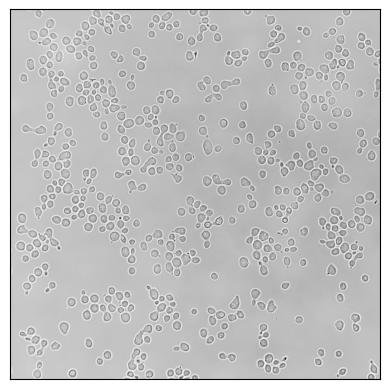

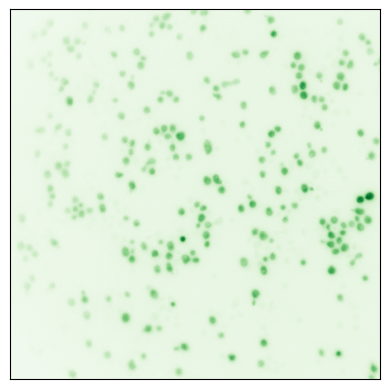

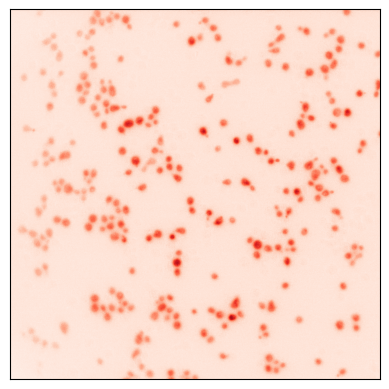

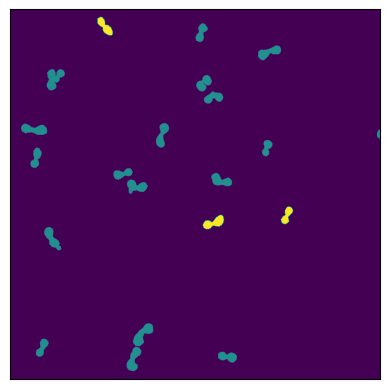

In [49]:
check_example = True
import matplotlib.pyplot as plt
%matplotlib inline

if check_example == True:
    print('loading img' )
    img = Image.open(dataset[0]['img'])
    img = [frame for frame in yield_frames(img,verbose=False)]
    print('loading gfp')

    gfp = Image.open(dataset[0]['gfp'])
    gfp = [frame for frame in yield_frames(gfp,verbose=False)]
    
    print('loading rfp')
    rfp = Image.open(dataset[0]['rfp'])
    rfp = [frame for frame in yield_frames(rfp,verbose=False)]

    ax = plt.imshow( img[0] , cmap = 'Greys')
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    plt.show()
    
    ax = plt.imshow( gfp[0] , cmap = 'Greens')
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    plt.show()
    
    ax = plt.imshow( rfp[0] , cmap = 'Reds')
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    plt.show()
    
    
    ax = plt.imshow( dataset[0]['maskmatrix'] )
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    plt.show()
    
    


In [50]:
from sklearn.preprocessing import RobustScaler
import numpy as np
import pickle



# Initialize the RobustScaler
scaler_bf = RobustScaler()

images_bf = np.stack([ dataset[sample]['stack_mat'][frame] for sample in dataset for frame in dataset[sample]['stack_mat'] ])
print('stacks' , images_bf.shape)

image_stack_bf = images_bf.reshape(-1, images_bf.shape[0])

print( 'fitting scalers ' ) 
scaler_bf.fit(image_stack_bf)

scalers = [scaler_bf]
print('scalers', scalers)
with open('scalers.pkl' , 'wb') as scalerdump:
    scalerdump.write(pickle.dumps(scalers))

stacks (77, 1024, 1024, 3)
fitting scalers 
scalers [RobustScaler()]


In [43]:
#apply data augmentation
#image augmentation for training

import cv2
import random
import numpy as np

def random_rotation(image, masks, angle_range):
    angle = random.uniform(-angle_range, angle_range)
    image =  Image.fromarray(  np.array( np.ones(image.shape)*256 - Image.fromarray(image)).astype(np.uint8) )
    image = image.rotate(angle)
    masks = [ Image.fromarray(m) for m in masks ]
    masks = [ m.rotate(angle) for m in masks ]
    return np.array(image), masks

def random_flip(image, masks):
    if random.random() > 0.5:
        image = cv2.flip(image, 1)
        masks = [ cv2.flip(np.array(m), 1) for m in masks]
    return image, masks

def random_augmentation(image, masks, angle_range, crop_size):
    
    image, masks = random_rotation(image, masks, angle_range)
    
    image, masks = random_flip(image, masks)
   
    
    #image, mask = random_crop(image, mask, crop_size)
    return image, masks

#resize to original size
def resize(image, mask, size):
    image = cv2.resize(image, size)
    mask = cv2.resize(mask, size)
    return image, mask

#apply augmentation and then resize to original size
def augment_and_resize(image, masks, angle_range=180, crop_size=900, size=[1024,1024]):
    image = image.astype(np.uint8)
    image, masks = random_augmentation(image, masks, angle_range, crop_size)
    masks = [np.array(m) for m in masks ]
    #image, masks = resize(image, masks, size)
    return image, masks

In [44]:

augmented_folder = 'augmented/'

In [45]:
import shutil
overwite = True
if overwite:
    try:
        shutil.rmtree(augmented_folder)
    except:
        pass
    os.mkdir(augmented_folder)
    os.mkdir(augmented_folder+'train')
    os.mkdir(augmented_folder+'train/images/')
    os.mkdir(augmented_folder+'train/labels/')
    os.mkdir(augmented_folder +'test')
    os.mkdir(augmented_folder+'test/images/')
    os.mkdir(augmented_folder + 'test/labels/')
    os.mkdir(augmented_folder +'val/')
    os.mkdir(augmented_folder +'val/images')
    os.mkdir(augmented_folder + 'val/labels')


In [46]:
verbose = False
import tqdm 
x_augment = 10
augmented = {}

count = 0
for sample in tqdm.tqdm(dataset):
    augmented[sample] ={}
    for frame in dataset[sample]['stack_mat']:
        image = dataset[sample]['stack_mat'][frame]
        mask = dataset[sample]['maskmatrix']
        masks = split_mask(mask)
        for i in range(x_augment):
            img , masks = augment_and_resize(image,masks)
            
            for m in masks:
                m[m>0] = 1
                
            if count < 10 and verbose == True:
                plt.imshow( img[:,:,0] , cmap = 'Greys')
                plt.colorbar( location = 'left')
                plt.show()
            augmented[sample]['mask'] = mask
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            cv2.imwrite(augmented_folder+'train/images/img_'+str(count)+'.png', im )
            augmented[sample]['img'] = augmented_folder+'train/images/img_'+str(count)+'.png'
            m1,m2,m3 = masks
            lines = output_contours(m1, 0 , verbose = verbose)
            lines += output_contours(m2, 1, verbose = verbose)
            lines += output_contours(m3, 2, verbose = verbose)
            with open(augmented_folder + 'train/labels/img_'+ str(count)+ '.txt', 'w') as f:
                for l in lines:
                    f.write(l)
            augmented[sample]['mask_poly'] = augmented_folder  +'train/labels/img_'+ str(count)+ '.txt'
            #add polygons
            count+=1
            

100%|██████████| 11/11 [02:40<00:00, 14.55s/it]


In [51]:
#move a fraction of the training data and corresponding labels to val
import random
import shutil
import os

datasetdir = 'datasets/'#augmented_folder

files = os.listdir(datasetdir +'train/images/')
print(files[0:100], '...')
random.shuffle(files)
val_files = files[:int(len(files)*.1)]
for f in val_files:
    shutil.move(datasetdir + 'train/images/'+f, datasetdir+'val/images/'+f)
    shutil.move(datasetdir +'train/labels/'+f.replace('.png', '.txt'), datasetdir + 'val/labels/'+f.replace('.png', '.txt'))

    
files = os.listdir(datasetdir+'train/images/')
random.shuffle(files)

test_files = files[:int(len(files)*.1)]
for f in test_files:
    shutil.move(datasetdir + 'train/images/'+f, datasetdir + 'test/images/'+f)
    shutil.move(datasetdir + 'train/labels/'+f.replace('.png', '.txt'), datasetdir + 'test/labels/'+f.replace('.png', '.txt'))



['img_21.png', 'img_55.png', 'img_43.png', 'img_59.png', 'img_60.png', 'img_65.png', 'img_17.png', 'img_28.png', 'img_52.png', 'img_22.png', 'img_76.png', 'img_37.png', 'img_69.png', 'img_47.png', 'img_33.png', 'img_48.png', 'img_54.png', 'img_50.png', 'img_40.png', 'img_73.png', 'img_26.png', 'img_11.png', 'img_39.png', 'img_18.png', 'img_61.png', 'img_38.png', 'img_19.png', 'img_45.png', 'img_7.png', 'img_75.png', 'img_67.png', 'img_12.png', 'img_36.png', 'img_8.png', 'img_13.png', 'img_62.png', 'img_5.png', 'img_63.png', 'img_31.png', 'img_6.png', 'img_46.png', 'img_58.png', 'img_25.png', 'img_51.png', 'img_30.png', 'img_68.png', 'img_2.png', 'img_44.png', 'img_70.png', 'img_66.png', 'img_1.png', 'img_42.png', 'img_29.png', 'img_74.png', 'img_3.png', 'img_0.png', 'img_24.png', 'img_20.png', 'img_23.png', 'img_41.png', 'img_16.png', 'img_9.png', 'img_57.png', 'img_34.png', 'img_32.png', 'img_15.png', 'img_4.png', 'img_10.png', 'img_53.png', 'img_71.png', 'img_14.png', 'img_72.png', '

In [76]:
#create traininging yaml file for the dataset

outyaml = """
train: train
val: val
test: test

names: 
    0: f
    1: h
    2: l
"""

with open('./dataset.yaml', 'w') as f:
    f.write(outyaml)


In [77]:
from ultralytics import YOLO
modelpath = 'yolov8n-seg_yfusion.pt'
import os


overwrite = True
if os.path.exists(modelpath) and overwrite == False:
    model = YOLO(modelpath)
else:
    #train the model
    model = YOLO("yolov8n-seg.pt")

In [ ]:
train = True
if train == True:
    results = model.train(
            batch=1,
            device=0,
            data='./dataset.yaml',
            epochs=5000,
            imgsz=1024,
            
        )

Ultralytics YOLOv8.1.10 🚀 Python-3.12.1 torch-2.2.0 CUDA:0 (NVIDIA A100-PCIE-40GB, 40339MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=./dataset.yaml, epochs=5000, time=None, patience=50, batch=1, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train33, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_b

train: Scanning /work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/segmentation_fluo/datasets/train/labels.cache... 63 images, 0 backgrounds, 0 corrupt: 100%|██████████| 63/63 [00:00<?, ?it/s]
/work/FAC/FBM/DBC/cdessim2/default/dmoi/miniconda3/envs/torch/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/segmentation_fluo/datasets/val/labels.cache... 7 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7/7 [00:00<?, ?it/s]
/work/FAC/FBM/DBC/cdessim2/default/dmoi/miniconda3/envs/torch/lib/python3.12/site-packages/torch/ut

Plotting labels to runs/segment/train33/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 8 dataloader workers
Logging results to runs/segment/train33
Starting training for 5000 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     1/5000      15.5G      2.163       3.86      4.105      1.592         32       1024: 100%|██████████| 63/63 [00:09<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.21it/s]

                   all          7        259   0.000873    0.00167   0.000488   0.000145          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     2/5000      11.6G      1.878       3.42      3.653      1.412         38       1024: 100%|██████████| 63/63 [00:07<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.36it/s]

                   all          7        259     0.0143     0.0679     0.0132    0.00662     0.0145     0.0859     0.0219    0.00554



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     3/5000      13.4G      1.811       3.21      3.333      1.376        130       1024: 100%|██████████| 63/63 [00:08<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.87it/s]

                   all          7        259     0.0499      0.335     0.0632     0.0318     0.0459      0.304     0.0608     0.0298



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     4/5000      11.6G      1.743      3.115      3.125      1.357         13       1024:  71%|███████▏  | 45/63 [00:05<00:02,  7.75it/s]

In [55]:
#save model
model.save('yolov8n-seg_yfusion.pt')

In [56]:
from ultralytics import YOLO

./validation/mprm1-mprm1-entr/RFP_Position001.tif
(1024, 1376, 3)


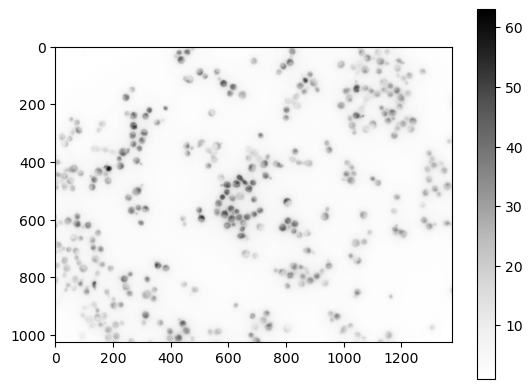

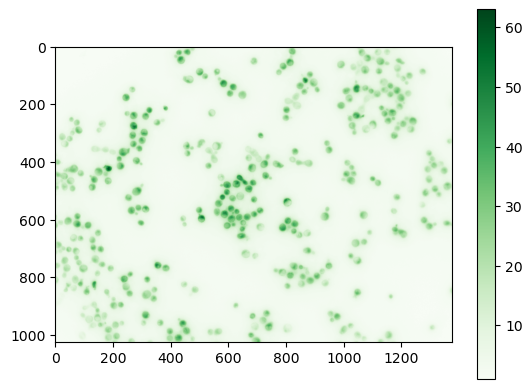

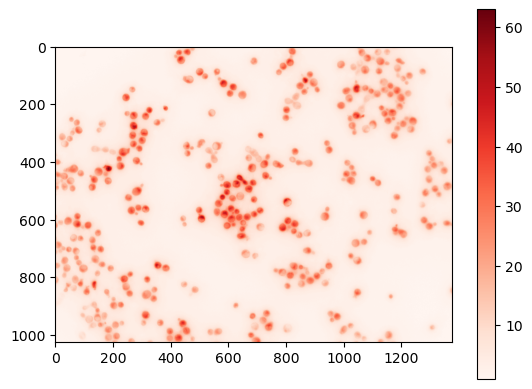

In [57]:
import glob
import cv2
from matplotlib import pyplot as plt
functional_testing_set = glob.glob('./validation/mprm1-mprm1-entr/*.tif' )
print( functional_testing_set[0 ] )
print(cv2.imread(functional_testing_set[0 ]).shape)

cscheme = [ 'Greys' , 'Greens', 'Reds' ]
sample = cv2.imread(functional_testing_set[0 ])
for channel in range(sample.shape[2] ):
    plt.imshow(sample[:,:,channel] , cmap = cscheme[channel])
    plt.colorbar()
    plt.show()

In [74]:
import pickle
#my_model = YOLO('yolov8n-seg_yfusion.pt')
my_model = YOLO('yolov8n-seg_yfusion.pt')

def scaleimg(imgfile):

    
    #scale each input channel
    im = cv2.imread(imgfile)
    for d in range(im.shape[2]):
        
        page = im[:,:,d]
        page = (page - page.min()) / (page.max() - page.min()) * 255
        im[:,:,d] = page
    im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    cv2.imwrite(imgfile +'_scaled.png', im )
    adjust_brightness_contrast(imgfile +'_scaled.png',imgfile +'_scaled.png')
    
    return imgfile +'_scaled.png'


functional_testing_set = glob.glob('./validation/mprm1-mprm1-entr/*.tif' )
predinput = [scaleimg(i) for i in functional_testing_set ]
#results = { img:my_model( img , conf=0.0) for img in predinput }
with open( 'functional_test.pkl' , 'wb' ) as resout:
    resout.write( pickle.dumps( results ))

In [75]:
print(results.keys())

dict_keys(['./validation/mprm1-mprm1-entr/RFP_Position001.tif_scaled.png', './validation/mprm1-mprm1-entr/GFP_Position010.tif_scaled.png', './validation/mprm1-mprm1-entr/GFP_Position007.tif_scaled.png', './validation/mprm1-mprm1-entr/BF_Position005.tif_scaled.png', './validation/mprm1-mprm1-entr/GFP_Position001.tif_scaled.png', './validation/mprm1-mprm1-entr/RFP_Position007.tif_scaled.png', './validation/mprm1-mprm1-entr/RFP_Position009.tif_scaled.png', './validation/mprm1-mprm1-entr/BF_Position007.tif_scaled.png', './validation/mprm1-mprm1-entr/BF_Position001.tif_scaled.png', './validation/mprm1-mprm1-entr/GFP_Position005.tif_scaled.png', './validation/mprm1-mprm1-entr/BF_Position010.tif_scaled.png', './validation/mprm1-mprm1-entr/RFP_Position005.tif_scaled.png'])



image 1/1 /work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/segmentation_fluo/validation/mprm1-mprm1-entr/RFP_Position001.tif_scaled.png: 480x640 (no detections), 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


0it [00:00, ?it/s]


<Figure size 1000x600 with 0 Axes>

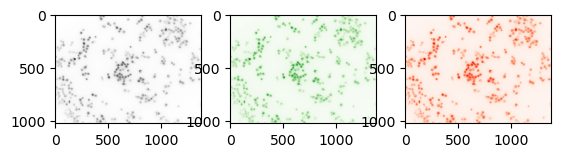

In [65]:
from matplotlib import patches
import tqdm

def add_rect(h,w,x,y , ax , color = 'r', label= '' ):
    # Create a Rectangle patch
    rect = patches.Rectangle((h, w), x, y, linewidth=3, edgecolor=color, facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    if len(label) > 0:
        ax.text(x - 20, y - 20 , label , )
    return ax

def plot_res(pred, imgfile):
    
    img = pred[0].orig_img
    boxes = pred[0].boxes.xywh.detach().cpu()
    c = pred[0].boxes.cls.detach().cpu()

    plt.figure(figsize=(10,6))

    fig,axes = plt.subplots(nrows=1, ncols=3)

    
    cscheme = [ 'Greys' , 'Greens', 'Reds' ]
    sample = cv2.imread(imgfile)
    for channel in range(img.shape[2] ):
        axes[channel].imshow(sample[:,:,channel] , cmap = cscheme[channel])
    for row in tqdm.tqdm(range(boxes.shape[0])):
        x,y,w,h = list( boxes[row,: ] )
        cstr = str(c[row])
        label = str( c[row] )
        for ax in list(axes):
            ax = add_rect(h=h,w=w,x=x,y=y , ax=ax , color = 'r', label= cstr )
    plt.show()


def output_pred(imgfile,my_model=my_model):
    results = list(my_model(imgfile, conf=0.1))
    plot_res(results, imgfile)

output_pred(predinput[0])

In [1]:
#visualize predicitions for the validation set
import random
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tqdm 

my_model = YOLO('runs/segment/train21/weights/best.pt')
results = list(my_model('datasets/test/images/img_57.png', conf=0.0))
result = np.asarray( results[0].conf.detach())
def retdf(model, predfile):
    resdict = { i:{ c:result[row,i] for i,c in enumerate(classes) } for i in result.shape[0] }
    resdf = pd.DataFrame(resdict)
    resdf['file'] = predfile
    return resdf

predfiles = glob.glob('*/')
global_resdf =  pd.concat([ retdf(my_model(imgfile, conf=0.0) ) for imgfile in tqdm.tdm(predfiles) ])

print(global_resdf )

NameError: name 'YOLO' is not defined

In [ ]:
print(results)

In [4]:
from IPython.display import Image as show_image
show_image(filename="runs/segment/train5/val_batch0_labelsYOLOjpg")

show_image(filename="runs/segment/train5/MaskP_curve.png")

show_image(filename="runs/segment/train5/results.png")



ValueError: Cannot embed the 'runs/segment/train5/val_batch0_labelsyolojpg' image format

In [ ]:
#augment dataset and dump to disk in pt format
